In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from itertools import combinations
import time
from numpy.linalg import inv
import math
import random

In [2]:
# Read pool of data points from hw3pool.txt
df = pd.read_csv("hw3pool.txt", sep=" ", header=None, names=['x', 'y'])
df.info()
display(df.head())

pool = df.to_numpy()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 30 entries, nan to nan
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       30 non-null     float64
 1   y       30 non-null     float64
dtypes: float64(2)
memory usage: 720.0 bytes


,x,y
NaN,2.374862,1.080289
NaN,2.946939,1.898605
NaN,1.650485,1.864033
NaN,3.270571,2.691074
NaN,1.168345,-3.032215


In [3]:
# This function implements the OLS estimator which takes in 1D features, x, expected values y as inputs, and returns two parameters
def ols_estimator_1d(x, y):
    
    m = x.shape[0] # Number of training examples
    
    # Dependent variable (1D) - X matrix
    X = np.array([np.ones(m), x]) 
    X = X.T # Transpose matrix to hold a shape of m x 2 to facilitate matrix multiplication of its transpose with vector y of shape m x 1 


    # Independent variable - y vector
    Y = y[..., None]

    # Implementing OLS Estimator
    # 1D OLS parameters - [\beta_{0}, \beta_{1}], y-intercept and gradient respectively
    betas = np.linalg.inv(X.T @ X) @ X.T @ Y 

    betas = betas.flatten()
    
    return betas

def regression_formula(x, beta1, beta2):
    return beta1 + beta2 * x

closeness = lambda a, b, p_a, p_b: (p_a - a)**2 + (p_b - b)**2

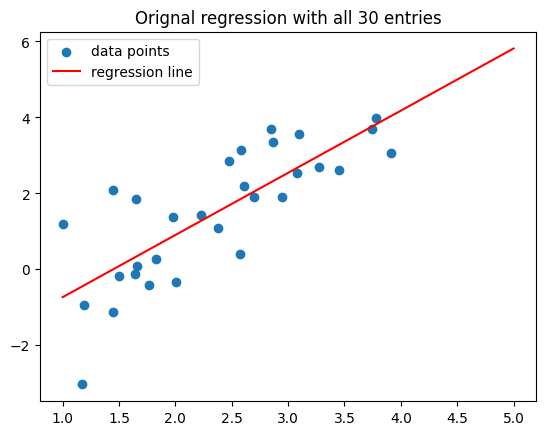

original beta 1: -2.370239547206875,
original beta 2: 1.637053151711282


In [4]:
# Run regression on all 30 entries
# On all 30 entries
x_all, y_all = pool.T
o_beta1, o_beta2 = ols_estimator_1d(x_all, y_all)

plt.scatter(x_all, y_all)

# Plot regression line
x_t = np.linspace(1,5, num=5)
plt.plot(x_t, regression_formula(x_t, o_beta1, o_beta2), c='red')

plt.title('Orignal regression with all 30 entries')
plt.legend(["data points", "regression line" ])
plt.show()

print(f'original beta 1: {o_beta1},\noriginal beta 2: {o_beta2}')

# Q1 

In [5]:
random.seed(3)

def find_combination(n, pool):
    dataset = combinations(pool, n)
    return np.array(list(dataset))

def find_best_teaching_set(n, greedy=False):

    minimum = math.inf
    best_teaching_set = None
    best_betas = None
    datasets = None 
    n_combinations = 0

    if greedy:
        start_dp_i = random.randint(0, len(df)-1)
        dataset = np.array([pool[start_dp_i]])
        filtered_pool = np.delete(pool, start_dp_i, axis=0)
        size = 2
        
        while size <= n:
            for dp in filtered_pool:
                n_combinations += 1
                datapoint = np.array([dp])
                new_dataset = np.append(dataset, datapoint, axis=0)
                temp_ds = new_dataset.T
                betas = ols_estimator_1d(temp_ds[0], temp_ds[1])
                closeness_v = closeness(o_beta1, o_beta2, betas[0], betas[1])
                if closeness_v <= minimum:
                    best_teaching_set = new_dataset
                    best_betas = betas
                    minimum = closeness_v
      
            # Handle intermediate failure to seek better regression
            if len(best_teaching_set) == size-1:
                # Select a random data point to append to the dataset
                start_dp_i = random.randint(0, len(df)-1)
                rand_dp = np.array([pool[start_dp_i]])
                dataset = np.append(best_teaching_set, rand_dp, axis = 0)
            else: 
                dataset = best_teaching_set
                 
            size+=1
    else: 
        datasets = find_combination(n, pool)
        
        for ds in datasets:
            temp_ds = ds.T
            betas = ols_estimator_1d(temp_ds[0], temp_ds[1])
            closeness_v = closeness(o_beta1, o_beta2, betas[0], betas[1])
            if(closeness_v <= minimum):
                best_teaching_set = ds
                best_betas = betas
                minimum = closeness_v

        n_combinations = len(datasets)
            
    return best_teaching_set, best_betas, n_combinations, minimum 
            
def run_and_time_function(func, *args):
    start = time.time()
    func(*args)
    end = time.time()
    return end-start

    
def print_metrics(n_teaching_size, time_cutoff, greedy= False):

    start = time.time()
    best_teaching_set, teaching_set_betas, n_combinations_iterated, closeness_measure = find_best_teaching_set(n_teaching_size, greedy)
    end = time.time()
    time_elapsed = end - start
   
    if time_elapsed < time_cutoff:
        # Show plot
        plt.scatter(x_all, y_all)

        # Plot original data points, and the original predicted regression line
        x_t = np.linspace(1,5, num=5)
        plt.plot(x_t, regression_formula(x_t, o_beta1, o_beta2), c='red')

        plt.title(f'Orignal regression with all 30 entries vs regression with best n={n_teaching_size} teaching data points')

        # Plot teaching data set used, and predicted regression line
        ts = best_teaching_set.T
        plt.scatter(ts[0], ts[1])
        plt.plot(x_t, regression_formula(x_t, teaching_set_betas[0], teaching_set_betas[1]))

        plt.legend(["original data points", "original regression line", "teaching data points", "teaching regression line" ])

        plt.show()

        print(f'Parameter loss (closeness measure): {closeness_measure}')
        print(f'Number of times need to fit OLS: {n_combinations_iterated}')
        print(f'Time elapsed to compute best teaching set: {time_elapsed}')
        return (closeness_measure, n_combinations_iterated, time_elapsed)
    
    return False 
    
    
def print_all_metrics_till_time_cutoff_seconds(start_n, time_cutoff, greedy = False):

    n = start_n 
    all_n_used = []
    all_closeness_measure = []
    all_n_combinations_iterated = []
    all_time_elapsed = [] 
    r = None 
    
    while (r := print_metrics(n, time_cutoff, greedy)):
        all_n_used.append(n)
        all_closeness_measure.append(r[0])
        all_n_combinations_iterated.append(r[1])
        all_time_elapsed.append(r[2]) 
        n+=1
        
    return all_n_used, all_closeness_measure, all_n_combinations_iterated, all_time_elapsed

## Q1. Finding teaching data points using normal enumeration technique 

Time cutoff used (s): 6.6


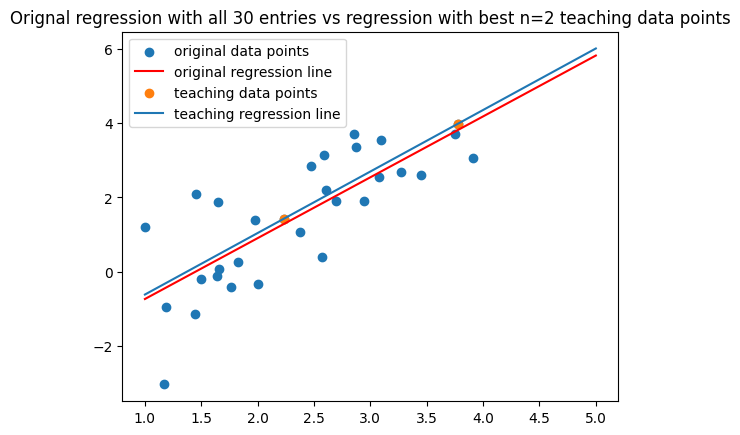

Parameter loss (closeness measure): 0.010804784411978798
Number of times need to fit OLS: 435
Time elapsed to compute best teaching set: 0.013870000839233398


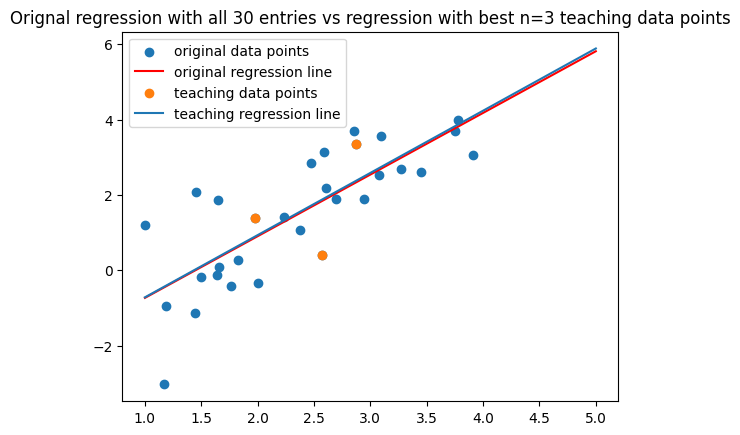

Parameter loss (closeness measure): 0.00021463796629338867
Number of times need to fit OLS: 4060
Time elapsed to compute best teaching set: 0.05362367630004883


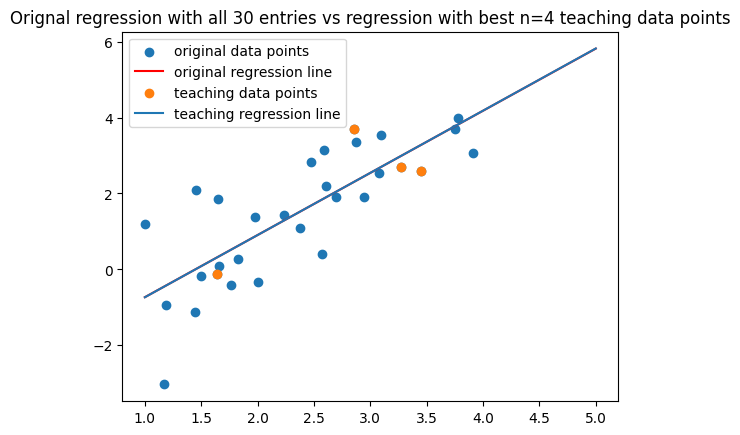

Parameter loss (closeness measure): 7.798436603588056e-06
Number of times need to fit OLS: 27405
Time elapsed to compute best teaching set: 0.29634690284729004


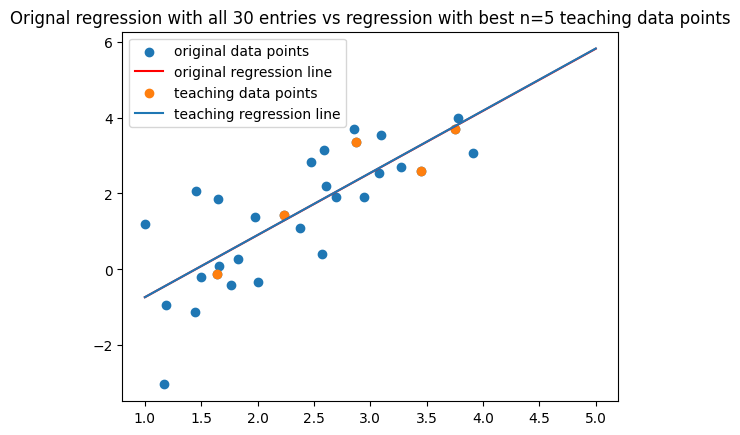

Parameter loss (closeness measure): 1.6605327753397655e-06
Number of times need to fit OLS: 142506
Time elapsed to compute best teaching set: 1.2401280403137207


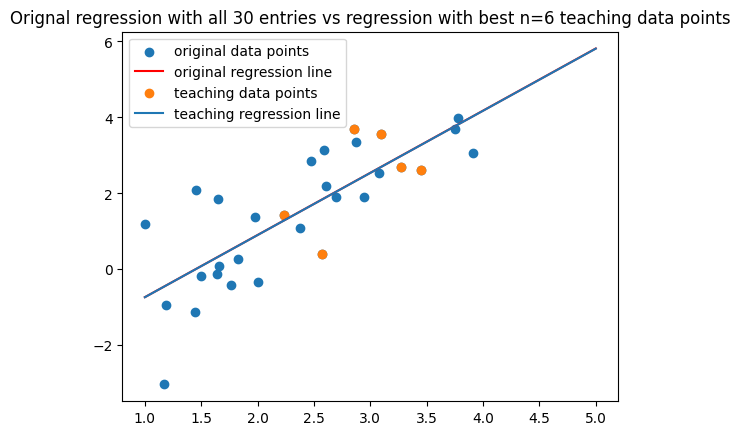

Parameter loss (closeness measure): 8.908127638734337e-07
Number of times need to fit OLS: 593775
Time elapsed to compute best teaching set: 4.678749084472656


In [6]:
time_cutoff = 6.6 
start_n = 2
greedy = False 
print(f'Time cutoff used (s): {time_cutoff}')

all_n_used, all_closeness_measure, all_n_combinations_iterated, all_time_elapsed = print_all_metrics_till_time_cutoff_seconds(start_n, time_cutoff, greedy)


# Q2

## Q2. Finding teaching data points using a greedy algorithm 

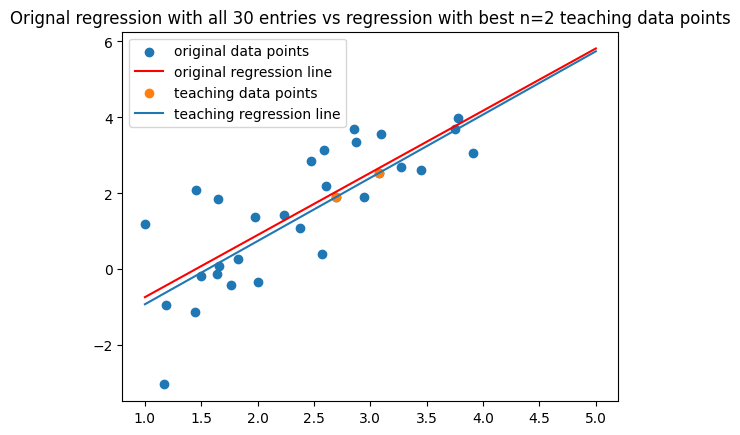

Parameter loss (closeness measure): 0.04706356056208622
Number of times need to fit OLS: 29
Time elapsed to compute best teaching set: 0.0013740062713623047


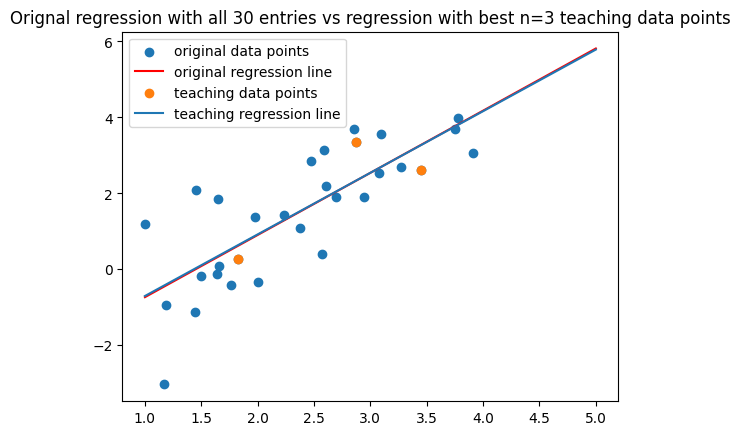

Parameter loss (closeness measure): 0.002285333422104582
Number of times need to fit OLS: 58
Time elapsed to compute best teaching set: 0.0006940364837646484


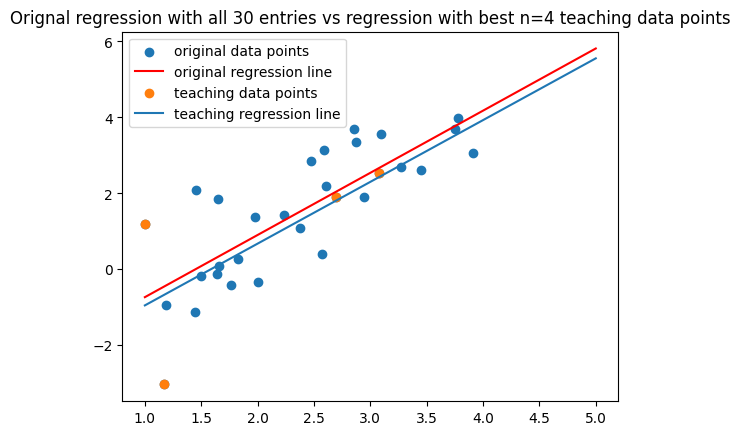

Parameter loss (closeness measure): 0.042558955339033686
Number of times need to fit OLS: 87
Time elapsed to compute best teaching set: 0.0012869834899902344


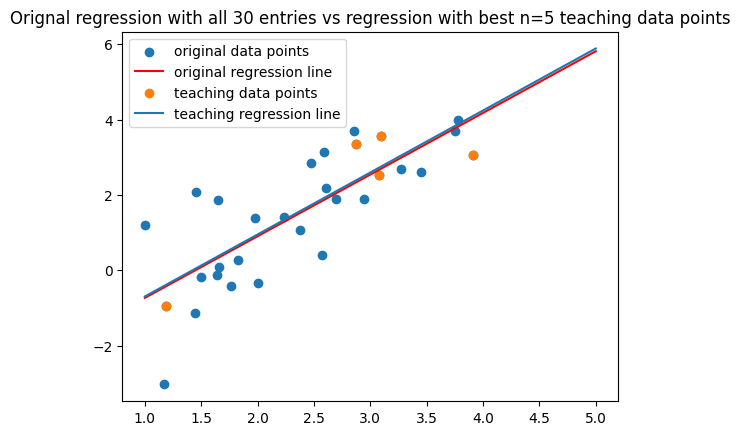

Parameter loss (closeness measure): 0.000880500313964734
Number of times need to fit OLS: 116
Time elapsed to compute best teaching set: 0.0025720596313476562


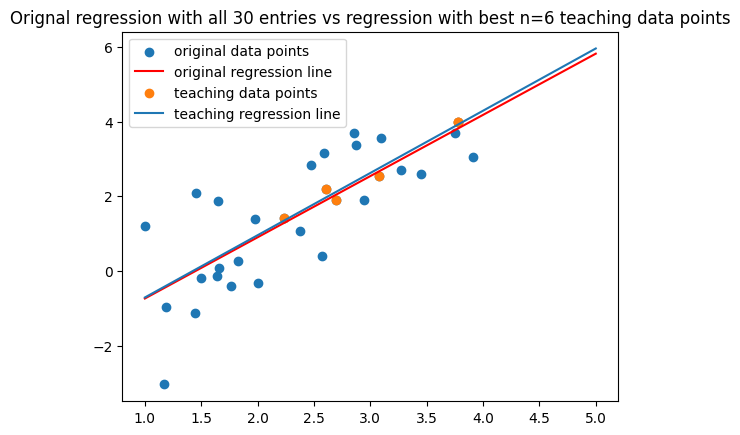

Parameter loss (closeness measure): 0.0007725018862666075
Number of times need to fit OLS: 145
Time elapsed to compute best teaching set: 0.0016520023345947266


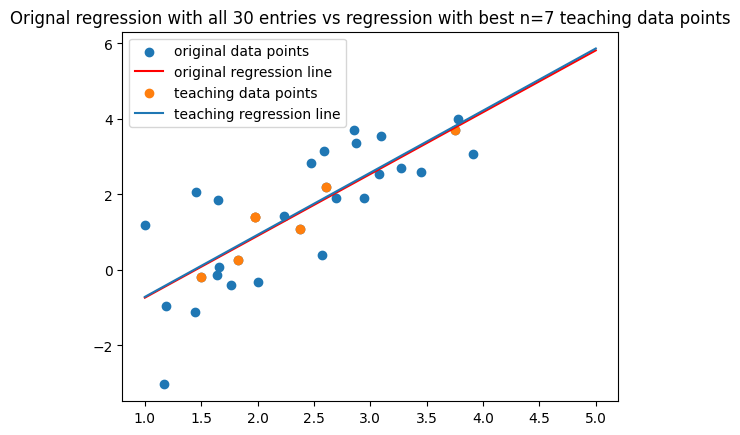

Parameter loss (closeness measure): 0.00023782695273841473
Number of times need to fit OLS: 174
Time elapsed to compute best teaching set: 0.0021028518676757812


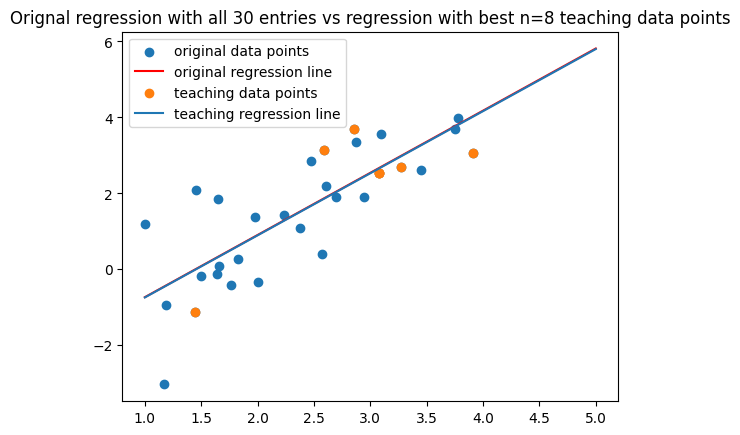

Parameter loss (closeness measure): 3.407611825008357e-05
Number of times need to fit OLS: 203
Time elapsed to compute best teaching set: 0.002651691436767578


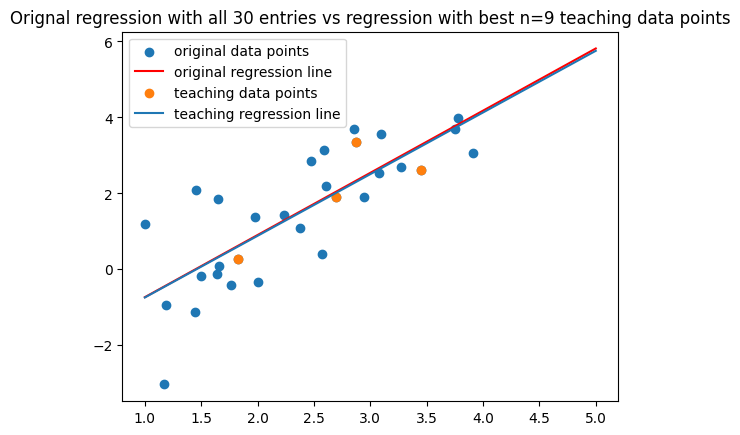

Parameter loss (closeness measure): 0.0002028839669426227
Number of times need to fit OLS: 232
Time elapsed to compute best teaching set: 0.0027740001678466797


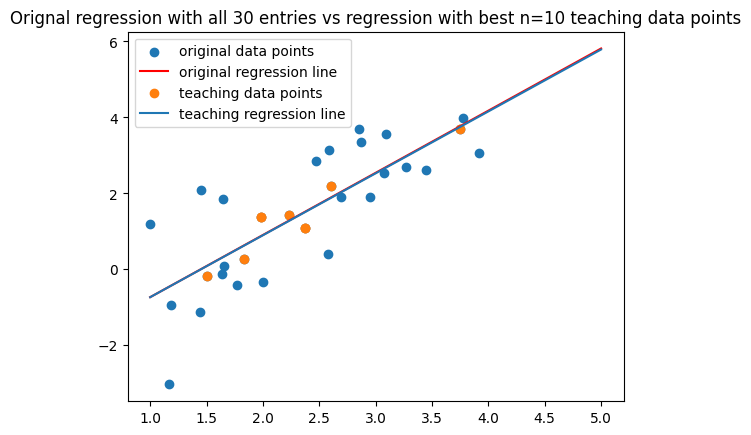

Parameter loss (closeness measure): 7.817025168677891e-05
Number of times need to fit OLS: 261
Time elapsed to compute best teaching set: 0.003675222396850586


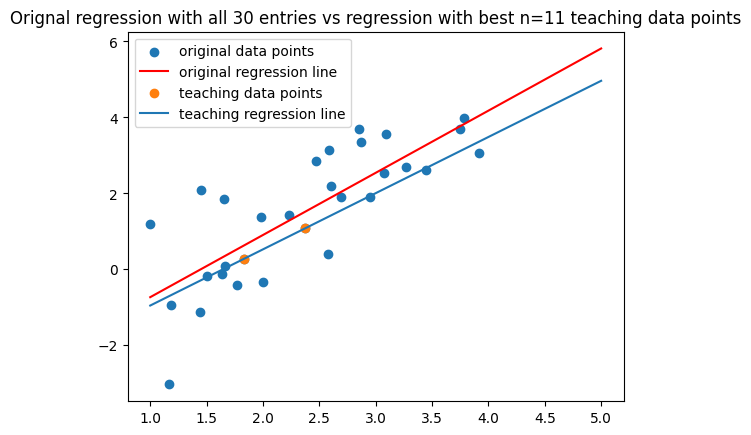

Parameter loss (closeness measure): 0.028804175279625133
Number of times need to fit OLS: 290
Time elapsed to compute best teaching set: 0.003342151641845703


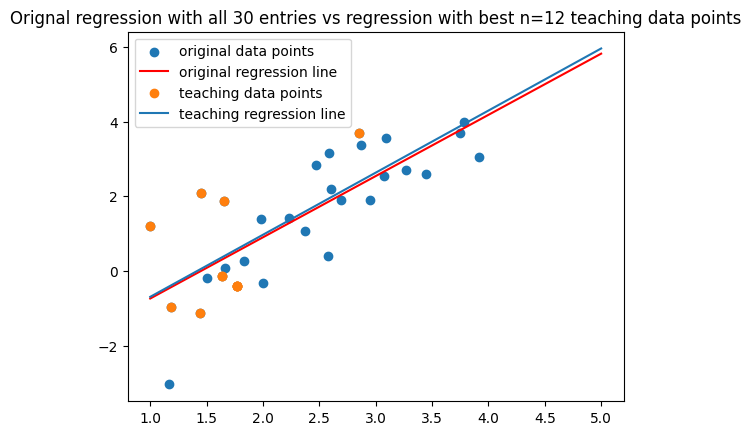

Parameter loss (closeness measure): 0.0009944806709111355
Number of times need to fit OLS: 319
Time elapsed to compute best teaching set: 0.004518032073974609


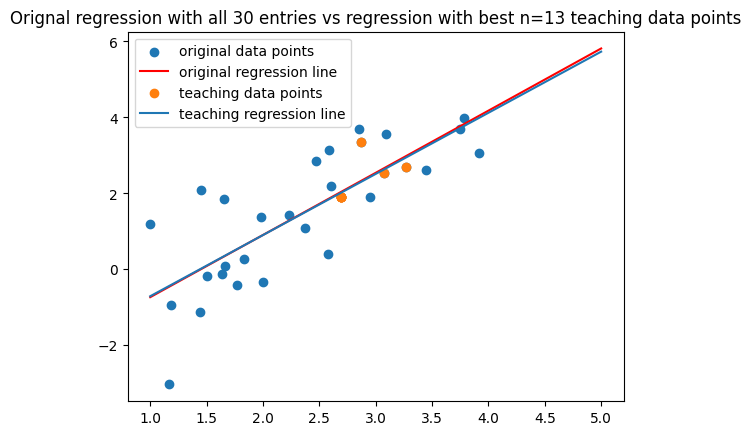

Parameter loss (closeness measure): 0.003434119581742071
Number of times need to fit OLS: 348
Time elapsed to compute best teaching set: 0.004068136215209961


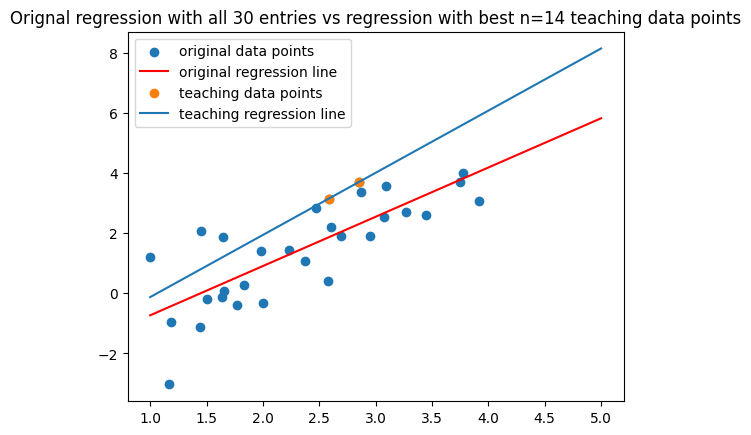

Parameter loss (closeness measure): 0.2146662198795381
Number of times need to fit OLS: 377
Time elapsed to compute best teaching set: 0.004309177398681641


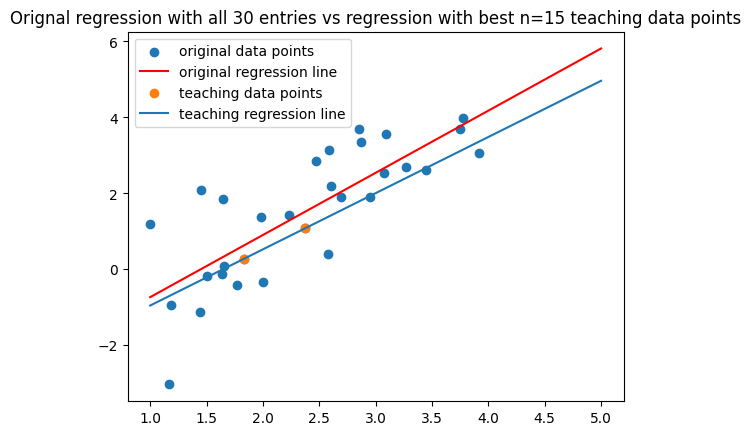

Parameter loss (closeness measure): 0.028804175279625133
Number of times need to fit OLS: 406
Time elapsed to compute best teaching set: 0.004745006561279297


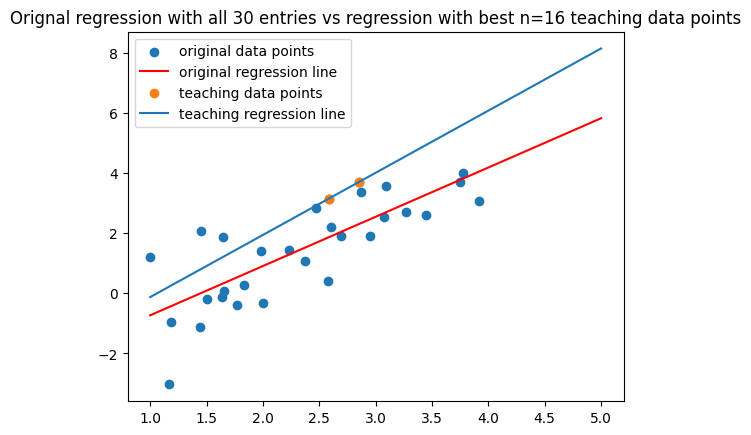

Parameter loss (closeness measure): 0.2146662198795381
Number of times need to fit OLS: 435
Time elapsed to compute best teaching set: 0.0049588680267333984


In [7]:
time_cutoff = 0.005
start_n = 2
greedy = True 
all_n_used_greedy, all_closeness_measure_greedy, all_n_combinations_iterated_greedy, all_time_elapsed_greedy = print_all_metrics_till_time_cutoff_seconds(start_n, time_cutoff, greedy)

## Metrics: normal enumeration technique vs a greedy algorithm

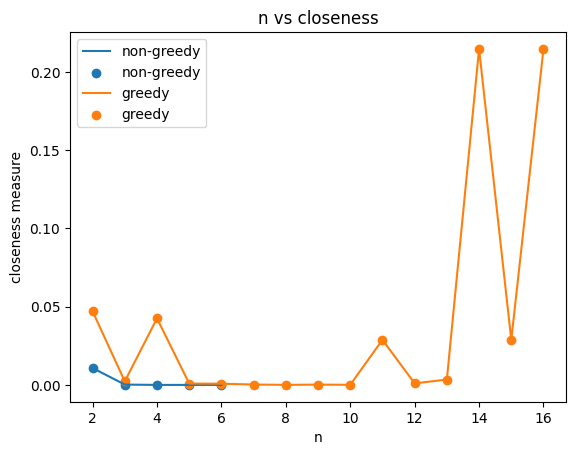

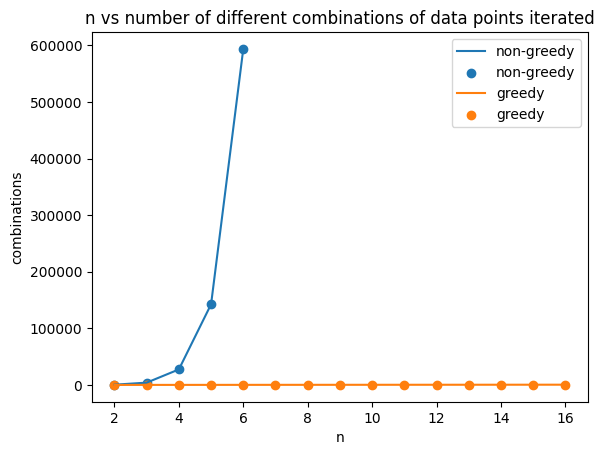

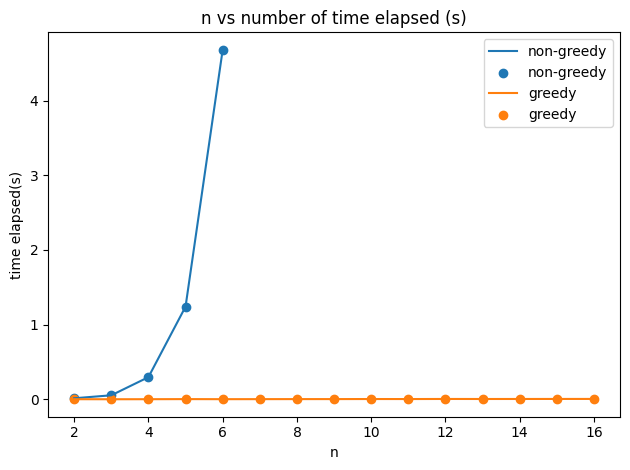

In [8]:
# Plot parameter loss with increasing nisinstance(temp_datasets, )
# Plot number of times needed to fit OLS with increasing n
# Plot time elapsed with increasing n

plt.plot(all_n_used, all_closeness_measure)
plt.scatter(all_n_used, all_closeness_measure)
plt.plot(all_n_used_greedy, all_closeness_measure_greedy)
plt.scatter(all_n_used_greedy, all_closeness_measure_greedy)
plt.xlabel('n')
plt.ylabel('closeness measure')
plt.title('n vs closeness')
plt.legend(['non-greedy','non-greedy','greedy','greedy'])
plt.show()

plt.plot(all_n_used, all_n_combinations_iterated)
plt.scatter(all_n_used, all_n_combinations_iterated)
plt.plot(all_n_used_greedy, all_n_combinations_iterated_greedy)
plt.scatter(all_n_used_greedy, all_n_combinations_iterated_greedy)
plt.xlabel('n')
plt.ylabel('combinations')
plt.title('n vs number of different combinations of data points iterated')
plt.legend(['non-greedy','non-greedy','greedy','greedy'])
plt.show()

plt.plot(all_n_used, all_time_elapsed)
plt.scatter(all_n_used,all_time_elapsed)
plt.plot(all_n_used_greedy, all_time_elapsed_greedy)
plt.scatter(all_n_used_greedy,all_time_elapsed_greedy)
plt.xlabel('n')
plt.ylabel('time elapsed(s)')
plt.title('n vs number of time elapsed (s)')
plt.legend(['non-greedy','non-greedy','greedy','greedy'])
plt.tight_layout()
plt.show()

# Q3